In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

#   Input variables (based on physicochemical tests):
#   1 - fixed acidity
#   2 - volatile acidity
#   3 - citric acid
#   4 - residual sugar
#   5 - chlorides
#   6 - free sulfur dioxide
#   7 - total sulfur dioxide
#   8 - density
#   9 - pH
#   10 - sulphates
#   11 - alcohol
#   Output variable (based on sensory data): 
#   12 - quality (score between 0 and 10)

schema = StructType([StructField('fixed_acidity', DoubleType(), True),
                     StructField('volatile_acidity', DoubleType(), True),
                     StructField('citric_acid', DoubleType(), True),
                     StructField('residual_sugar', DoubleType(), True),
                     StructField('chlorides', DoubleType(), True),
                     StructField('free_sulfur_dioxide', DoubleType(), True),
                     StructField('total_sulfur_dioxide', DoubleType(), True),
                     StructField('denisty', DoubleType(), True),
                     StructField('pH', DoubleType(), True),
                     StructField('sulphates', DoubleType(), True),
                     StructField('alchocol', DoubleType(), True),
                     StructField('label', DoubleType(), True)])

df = sqlContext.read.format('csv').load('winequality-white.csv', schema = schema, sep = ',')
df.count()

4898

In [2]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


columnNames = ['fixed_acidity', 'volatile_acidity', 'citric_acid',
               'residual_sugar','chlorides', 'free_sulfur_dioxide',
               'total_sulfur_dioxide', 'pH',
               'sulphates', 'alchocol']

assembler = VectorAssembler(inputCols = columnNames, outputCol = 'features')

In [3]:
sample_data = df.sample(False, 0.5).toPandas()
sample_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,denisty,pH,sulphates,alchocol,label
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
2,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,5.0


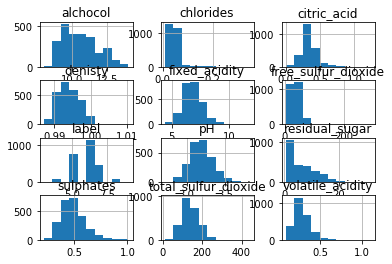

In [4]:
# distribution of features
import matplotlib.pyplot as plt

sample_data.hist(stacked = False, layout = (4, 3))
plt.show()

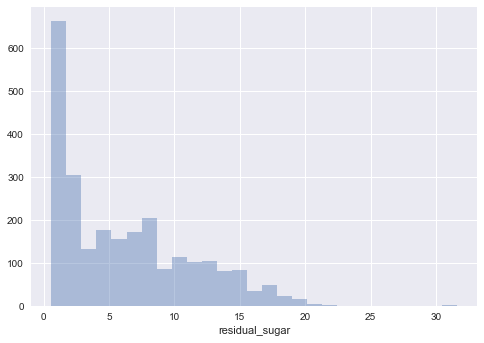

In [5]:
import seaborn as sb

sb.distplot(sample_data['residual_sugar'], kde = False)
plt.show()

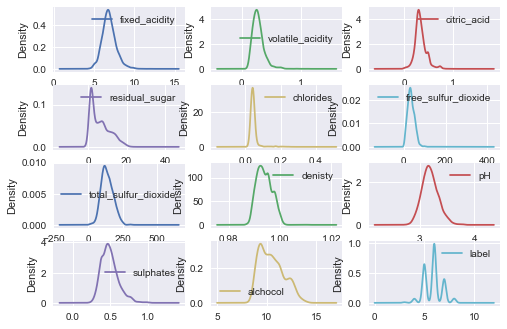

In [6]:
# Density plots are another way of getting a quick idea of the distribution of each attribute.

sample_data.plot(kind='density', subplots = True, layout = (4, 3), sharex = False)
plt.show()

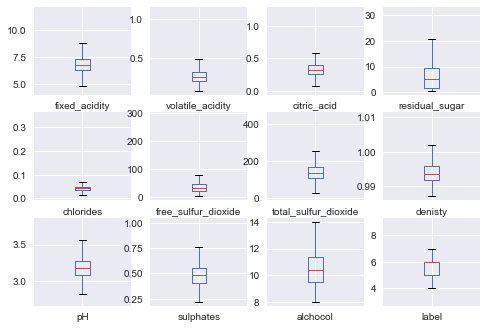

In [7]:
# Boxplots summarize the distribution of each attribute, drawing a line for the median 
# min, Q1(sredina prvog dela), median, Q2(- || -), max

sample_data.plot(kind='box', subplots=True, layout=(3, 4), sharex = False, sharey = False)
plt.show()

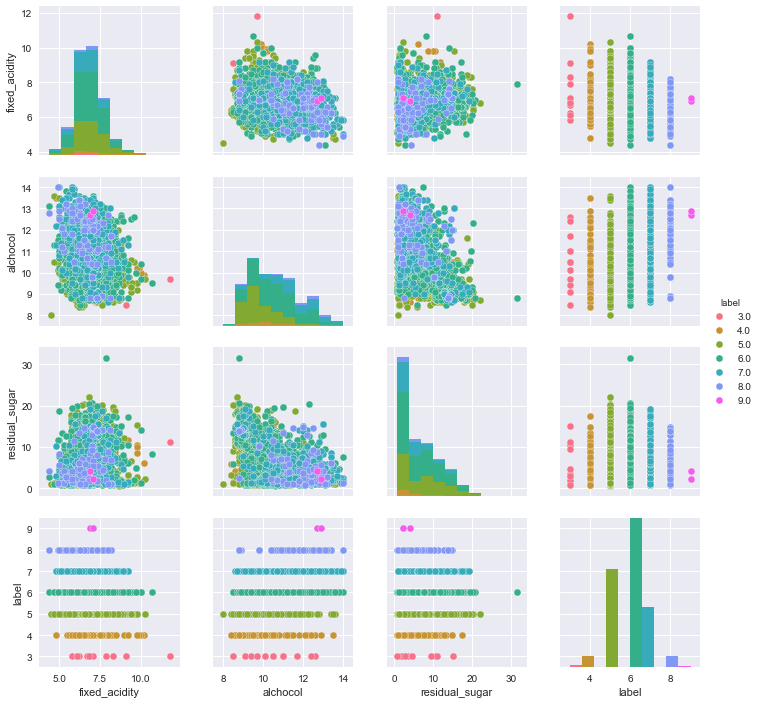

In [8]:
# Joint Distributions
# Looking at joint distributions of data can also tell us a lot, particularly about redundant features.

sb.pairplot(sample_data[['fixed_acidity', 'alchocol', 'residual_sugar', 'label']], hue = 'label')
plt.show()

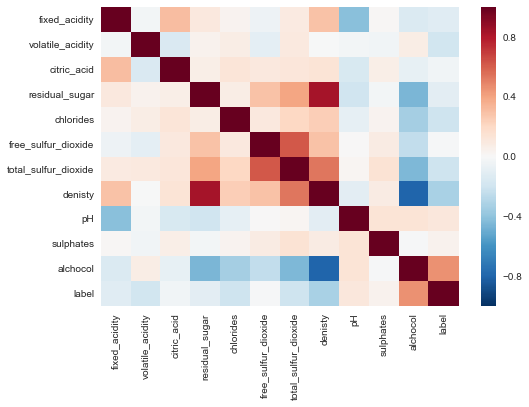

In [9]:
# Correlation Matrix Plot (Heatmap)

corr = sample_data.corr()
sb.heatmap(corr)
plt.show()

In [10]:
# testing Normalizer

from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Normalizer

normalizer = Normalizer(inputCol = 'features', outputCol = 'normData', p = 1.0)
asmData = assembler.transform(df)
normData = normalizer.transform(asmData)
normData.take(1)

[Row(fixed_acidity=7.0, volatile_acidity=0.27, citric_acid=0.36, residual_sugar=20.7, chlorides=0.045, free_sulfur_dioxide=45.0, total_sulfur_dioxide=170.0, denisty=1.001, pH=3.0, sulphates=0.45, alchocol=8.8, label=6.0, features=DenseVector([7.0, 0.27, 0.36, 20.7, 0.045, 45.0, 170.0, 3.0, 0.45, 8.8]), normData=DenseVector([0.0274, 0.0011, 0.0014, 0.081, 0.0002, 0.176, 0.665, 0.0117, 0.0018, 0.0344]))]

In [11]:
#from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

clf = LinearRegression(maxIter = 10, regParam = 0.0, elasticNetParam = 0.0)
#clf = GeneralizedLinearRegression(family = 'gaussian', link = 'identity', maxIter = 10, regParam = 0.3)


#pipeline = Pipeline(stages = [assembler, clf])

(train, test) = asmData.randomSplit([0.8, 0.2])

lrModel = clf.fit(train)

# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Summarize the model over the training set and print out some metrics
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
#trainingSummary.residuals.show()
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

#metrics = lrModel.evaluate(test)
preds = lrModel.transform(test)
preds = preds[['label', 'prediction']]
preds = preds.toPandas() # table visualisation *_*
preds.head(20)


Coefficients: [-0.0434080251962,-1.92062036234,0.0928819332898,0.0276437482046,-1.44742656568,0.0046796761367,-0.000850757249162,0.181763235196,0.405366410692,0.367643402541]
Intercept: 1.8935808431856775
numIterations: 1
objectiveHistory: [0.0]
RMSE: 0.755418
r2: 0.280404


,label,prediction
0,6.0,6.805193
1,8.0,6.937967
2,7.0,6.187819
3,5.0,5.363054
4,7.0,6.963986
5,6.0,6.305429
6,5.0,5.471415
7,5.0,5.471415
8,6.0,6.522919
9,8.0,6.284497


In [39]:
from pyspark.ml.regression import GeneralizedLinearRegression


clf = GeneralizedLinearRegression(family = 'gaussian', link = 'identity', maxIter = 10, regParam = 0.0)

model = clf.fit(train)

# Print the coefficients and intercept for generalized linear regression model
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

# Summarize the model over the training set and print out some metrics
# summary = model.summary
# print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
# print("T Values: " + str(summary.tValues))
# print("P Values: " + str(summary.pValues))
# print("Dispersion: " + str(summary.dispersion))
# print("Null Deviance: " + str(summary.nullDeviance))
# print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
# print("Deviance: " + str(summary.deviance))
# print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
# print("AIC: " + str(summary.aic))
# print("Deviance Residuals: ")
#summary.residuals().show()

predictions = model.transform(test)
predictions.select("label", "prediction").show(20)

Coefficients: [-0.0664151301821,-1.9256897229,-0.0230396291357,-1.90798753933,0.00576853434123,-0.000406737708008,0.0256657575551,0.342917247939,0.326576805369]
Intercept: 3.1381717387079093
+-----+------------------+
|label|        prediction|
+-----+------------------+
|  6.0| 6.580121556716019|
|  5.0| 6.114556973925209|
|  7.0| 6.403741034022762|
|  7.0| 6.276511111404563|
|  5.0| 5.788579957575138|
|  5.0| 6.090388054376515|
|  5.0| 5.869918351106161|
|  6.0| 5.826244777717486|
|  6.0| 6.337085045637227|
|  6.0| 5.663641237911379|
|  8.0| 6.165577296422853|
|  7.0|6.6959209266586885|
|  6.0| 6.102636461592544|
|  7.0|   6.4919047172848|
|  6.0| 5.803383934140899|
|  8.0| 6.701024788363849|
|  7.0| 6.739069101911253|
|  5.0| 5.921643293587616|
|  8.0|  6.17299263258353|
|  4.0| 5.377403374894044|
+-----+------------------+
only showing top 20 rows



In [40]:
from pyspark.ml.regression import DecisionTreeRegressor

# Train a DecisionTree model.
dt = DecisionTreeRegressor(featuresCol = "features")

model = clf.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("label", "prediction", "features").show(20)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# summary only
print(dt)

+-----+------------------+--------------------+
|label|        prediction|            features|
+-----+------------------+--------------------+
|  6.0| 6.580121556716019|[4.7,0.145,0.29,0...|
|  5.0| 6.114556973925209|[4.7,0.335,0.14,0...|
|  7.0| 6.403741034022762|[4.8,0.17,0.28,0....|
|  7.0| 6.276511111404563|[4.8,0.26,0.23,0....|
|  5.0| 5.788579957575138|[4.8,0.33,0.0,0.0...|
|  5.0| 6.090388054376515|[4.9,0.335,0.14,0...|
|  5.0| 5.869918351106161|[5.0,0.24,0.19,0....|
|  6.0| 5.826244777717486|[5.0,0.33,0.16,0....|
|  6.0| 6.337085045637227|[5.0,0.33,0.23,0....|
|  6.0| 5.663641237911379|[5.0,0.44,0.04,0....|
|  8.0| 6.165577296422853|[5.0,0.55,0.14,0....|
|  7.0|6.6959209266586885|[5.1,0.25,0.36,0....|
|  6.0| 6.102636461592544|[5.1,0.29,0.28,0....|
|  7.0|   6.4919047172848|[5.2,0.21,0.31,0....|
|  6.0| 5.803383934140899|[5.2,0.28,0.29,0....|
|  8.0| 6.701024788363849|[5.2,0.3,0.34,0.0...|
|  7.0| 6.739069101911253|[5.2,0.31,0.2,0.0...|
|  5.0| 5.921643293587616|[5.3,0.23,0.56

In [43]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = "features")


# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)


# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

predictions.select("label", "prediction").show(20)

Root Mean Squared Error (RMSE) on test data = 0.696925
+-----+------------------+
|label|        prediction|
+-----+------------------+
|  6.0| 6.308623753297995|
|  5.0| 5.884068811783686|
|  7.0| 6.395321196158332|
|  7.0| 6.266166258807283|
|  5.0| 5.808980173538989|
|  5.0| 5.884068811783686|
|  5.0| 5.608024055756115|
|  6.0| 5.436348907126124|
|  6.0| 6.574315500254061|
|  6.0|    5.689066566068|
|  8.0| 6.489557499628212|
|  7.0| 6.595024416906625|
|  6.0| 6.389258103494647|
|  7.0| 6.173786960330955|
|  6.0| 5.611653555009686|
|  8.0| 6.463288331390162|
|  7.0|6.5901222285769965|
|  5.0| 5.724192957508258|
|  8.0| 6.345446648353265|
|  4.0| 5.378933067828412|
+-----+------------------+
only showing top 20 rows

